# Durum Bilgisi Olan RNN ile Tahmin

## Gerekli Hazırlıkların Yapılması

Bu colab dosyasında tekrardan aşina olduğumuz paketleri içeri aktaracağız ve daha önceki colab dosyalarında oluşturduğum işlevleri kullanmak için tekrar tanımlıyoruz.

Tanımlamalarda sonra daha önceki colab dosyalarında oluşturduğumuz trend, mevsimsellik ve biraz beyaz gürültüye sahip olan zaman serisini tekrar oluşturuyoruz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Zaman")
    plt.ylabel("Değer")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Her periyotta aynı kalıbı tekrarlar"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

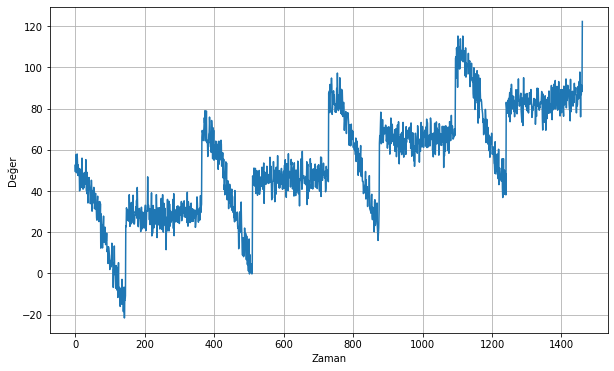

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful (Durum Bilgisi Olan) RNN ile Tahmin

Durum bilgisi olan RNN için ver kümesi oluşturmak için yeni bir işlev tanımlamamız gereklidir. Bu işlev önceki işleve oldukça benzerdir. `.windows` yönetemi çağrılırken `shift` parametresine 1 değeri yerine pencere boyutu (`window_size`) olacaktır. Böylece her pencere kendincen önceki pencereyi takip edecek şekilde oluşturulmuş olur.

İkinci bir değişiklik ise artık pencereleri karıştırmıyoruz (`shuffle`). RNN bu tür bir modelin oluşturulacağı zaman pencerelerin sıralı olmasını bekler. 

Son olarak ise tek tek bir pencere içeren gruplar (`batch(1)`) oluşturmak isteriz.

In [5]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

İşlevimizi gerekli değişiklikler ile güncelledikten sonra makine öğrenmesi için girdileri nasıl oluşturduğuna bakalım:

In [6]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


Bununla beraber her yenileme (epoch) başında modelin durumunun sıfırlanması gereklidir. Bunun için `keras.callbacks.Callback` sınıfını kullanarak kendi sınıfımızı oluşturuyoruz. `fit` yöntemi içerisinde bulunan `callbacks` listesine de eklememiz gerektiğini unutmayalım.

In [7]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()


Şimdi oluşturduğumuz modele bir adet geri arama (callbacks) tanımlayalım ve kerasın LearningRateScheduler işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (lr_schedule) bulunur.

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
33/33 [==============================] - 5s 37ms/step - loss: 105.9340 - mae: 106.4339
Epoch 2/100
33/33 [==============================] - 1s 35ms/step - loss: 70.8571 - mae: 71.3571
Epoch 3/100
33/33 [==============================] - 1s 35ms/step - loss: 39.8079 - mae: 40.3047
Epoch 4/100
33/33 [==============================] - 1s 37ms/step - loss: 27.3450 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 1s 35ms/step - loss: 24.4956 - mae: 24.9891
Epoch 6/100
33/33 [==============================] - 1s 36ms/step - loss: 23.2601 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 1s 36ms/step - loss: 22.0604 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 1s 36ms/step - loss: 20.8543 - mae: 21.3463
Epoch 9/100
33/33 [==============================] - 1s 35ms/step - loss: 19.8307 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 1s 36ms/step - loss: 18.9399 - mae: 19.4319
Epoch 11/100
33/33 [=======

Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:

(1e-08, 0.0001, 0.0, 30.0)

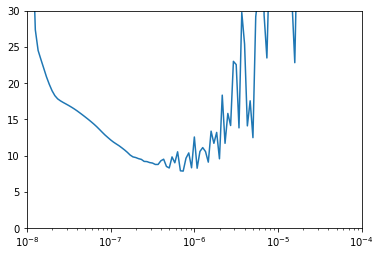

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Grafiği incelediğimizde en uygun değerin 1e-7 olacağını kabul edebiliriz. 1e-6 değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=10` argümanı 10 yinelemede (`epochs`) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

`early_stopping` gibi bize yardımcı olabilecek bir diğer `callbacks` çeşidi `model_checkpoint`'dir. Kayıt notları (`model_checkpoint`) model eğitilirken modelin durumunun iyiye gittiği her yineleme sonrası modeli bir kayıt noktası olarak kaydeder. Eğitim tamamlandığında en iyi modeli seçerek kullanabiliriz.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`. Aynı zamanda `fit` içerisinde callbacks listesine tanımladığımız erken durdurma işlevini ve kontrol noktasını eklememiz gerekecektir.

Ve son olarak epochs değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
33/33 [==============================] - 3s 51ms/step - loss: 60.2497 - mae: 60.7477 - val_loss: 25.0215 - val_mae: 25.5176
Epoch 2/500
33/33 [==============================] - 1s 41ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 1s 41ms/step - loss: 18.7249 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 1s 40ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 40ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 


Görüldüğü gibi erken durdurma işlevimiz  henüz 71. yinelemeden sonra modelimizin eğitimini durdurdu.

En iyi modelimizi seçmek için `keras.models.load_model` işlevini kullanıyoruz ve en başarılı modelimizi `model` adlı değişkene atıyoruz.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (model_forecast) oluşturuyoruz. 

In [12]:
model = keras.models.load_model("my_checkpoint.h5")

In [13]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

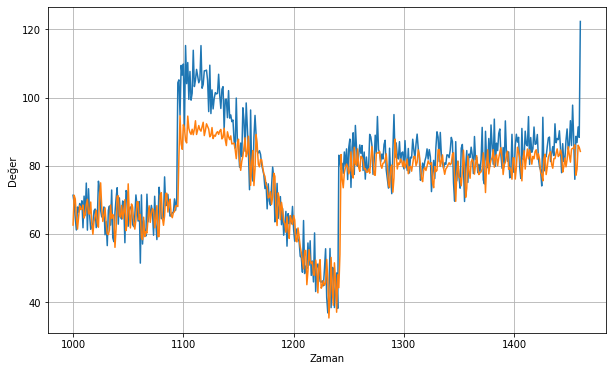

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Modelimizin performansını ölçelim ve ortalama mutlak hata (mae) değerimizi bulalım.

In [15]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778363